In [44]:
import numpy as np 
import os
import sys
import xarray as xr
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

proj_dir = os.path.join(os.pardir,os.pardir)
data_dir = os.path.join(proj_dir,'data','analysis')
int_dir = os.path.join(data_dir,'interim')
src_dir = os.path.join(proj_dir,'src')
fig_dir = os.path.join(proj_dir,'reports','shallow_melting','figures')

sys.path.append(src_dir)
from tools.log_progress import log_progress

# interpolating onto waom2 grid for nudging

In [ ]:
susheel_raw_path = os.path.join(data_dir,'external','susheel','ant_all_meltrate_2011-2017_10km_filt.nc')
waom_grd_path = os.path.join(proj_dir,'data','preprocessing','processed','waom2_grd.nc')
melting_figure_out_path = os.path.join(proj_dir,'reports','figures','susheel_melting.png')
mass_loss_table_out_path = os.path.join(proj_dir,'reports','tables','susheel_mass_loss.csv')

In [2]:
susheel = xr.open_dataset(susheel_raw_path)
waom_grd= xr.open_dataset(waom_grd_path)

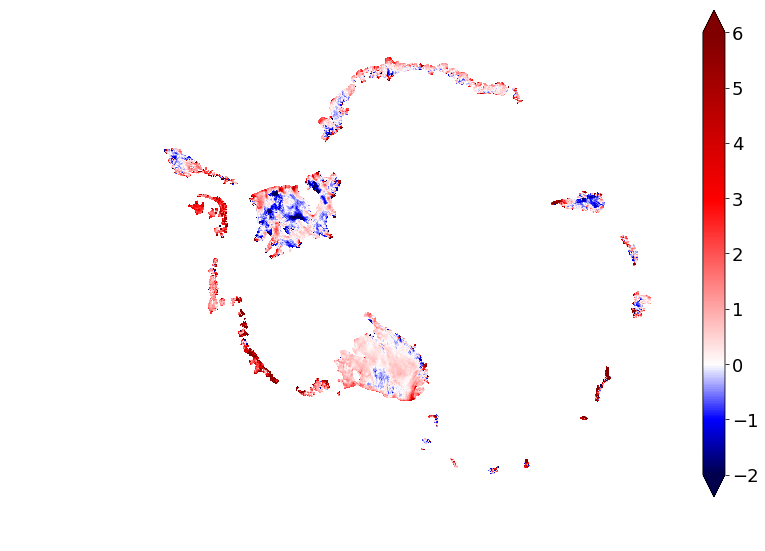

In [26]:
from visualization.shiftedColorMap import shiftedColorMap
import matplotlib
m_max=6
m_min=-2

m_cmap = shiftedColorMap(plt.cm.seismic,midpoint= (1 - m_max/(m_max + abs(m_min))))
matplotlib.rcParams.update({'font.size': 18})

plt.close()
fig,ax = plt.subplots(figsize=(15,8))
susheel.w_b.plot(vmin=m_min,vmax=m_max,ax=ax,cmap=m_cmap,cbar_kwargs={'label':''})
ax.set_aspect('equal')
ax.axis('off')
plt.tight_layout()
plt.show()

In [22]:
s_dat = susheel.w_b.values
s_mask = susheel.mask.values
s_lon = np.fliplr(np.rot90(susheel.lon.values,3))
s_lat = np.fliplr(np.rot90(susheel.lat.values,3))
ii = ~np.isnan(s_dat)
s_dat = s_dat[ii]
s_lon = s_lon[ii]
s_lat = s_lat[ii]
t_lon = waom_grd.lon_rho.data
t_lat = waom_grd.lat_rho.data
t_dat = griddata((s_lon.flatten(),s_lat.flatten()),s_dat.flatten(),(t_lon,t_lat),'nearest')

In [284]:
t_dat[(waom_grd.mask_rho == 0) | (waom_grd.zice == 0.0)] = np.nan
wb = xr.DataArray(t_dat, dims = ['eta_rho','xi_rho'])
wb.coords['lat_rho'] = waom_grd.lat_rho
wb.coords['lon_rho'] = waom_grd.lon_rho

In [285]:
int_file_out_path = os.path.join(data_dir,'processed','susheel_on_waom2grd.nc')
wb.to_netcdf(int_file_out_path)

In [16]:
from visualization.shiftedColorMap import shiftedColorMap
import matplotlib
def plot_ismr_map(m,grd,title,m_min=-1,m_max=6,out_path=False):

    m_cmap = shiftedColorMap(plt.cm.seismic,midpoint= (1 - m_max/(m_max + abs(m_min))))
    
    mask = (grd.zice < 0.0)&(grd.mask_rho==1)
    land_zice = (grd.mask_rho==0) | (grd.zice < 0.0)
    matplotlib.rcParams.update({'font.size': 18})
    
    plt.close()
    fig,ax = plt.subplots(figsize=(15,8))
    ax.contourf(grd.mask_rho.where(land_zice).values,colors=(('0.6','0.6','0.6')))
    (m.where(mask)).plot(vmin=m_min,vmax=m_max,ax=ax,cmap=m_cmap,cbar_kwargs={'label':''})
    ax.contour(-grd.zice.where(grd.mask_rho).values, levels=['0.01'], colors=('black'),linewidths=0.5)
    ax.contour(grd.mask_rho.values, levels=['0.01'], colors=('black'),linewidths=0.5)
    
    plt.title(title, fontsize=20)
    ax.set_aspect('equal')
    ax.axis('off')
    plt.tight_layout()
    if out_path:
        plt.savefig(out_path,format='png',dpi=375)
    plt.show()

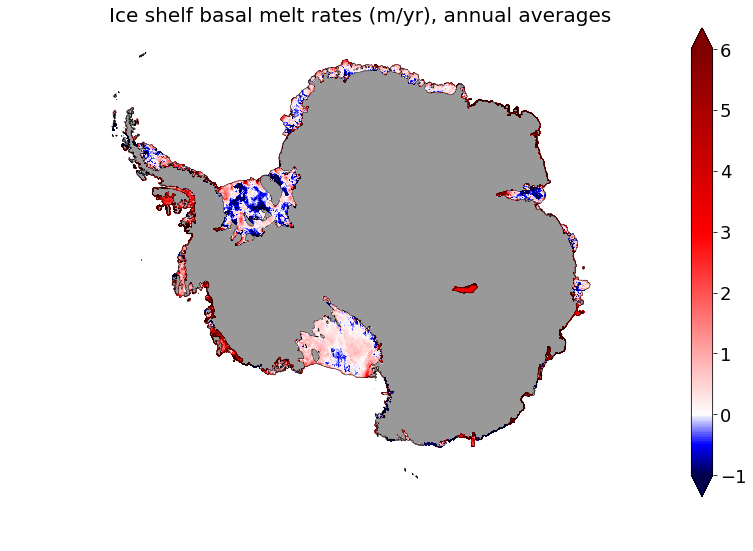

In [19]:
plot_ismr_map(wb.where(t_mask),waom_grd,
              "Ice shelf basal melt rates (m/yr), annual averages",
              -1,6)

In [288]:
def calc_antarctic_mass_loss(m,grd):

    rhoi = 916
    
    ice_shelf = (grd.mask_rho==1) & (grd.zice<0.0) 
    vostock = (grd.lat_rho<-75) & (grd.lat_rho>-80) & (grd.lon_rho>95) & (grd.lon_rho<115)
    
    mask = ice_shelf & ~vostock
    
    dA = (1/(grd.pm*grd.pn)).where(mask)
    weights = dA/dA.sum()
    
    ismr = (m.where(mask)*weights).sum()
    bmb = (m.where(mask)*dA*rhoi*10**-12).sum()
    
    print('Area of all ice shelves in 10^3 km^2: ',dA.sum().values*10**-9)
    print('Area average melt rate in m/yr: ',ismr.values)
    print('Basal mass loss in Gt/a: ',bmb.values)
    
    return

In [289]:
calc_antarctic_mass_loss(wb,waom_grd)

Area of all ice shelves in 10^3 km^2:  1617.6153939146484
Area average melt rate in m/yr:  0.9393432179306677
Basal mass loss in Gt/a:  1391.8583813364512


# Interpolating it onto Bedmap2 for depth melting

In [2]:
import h5py
from tools.inverse_polar_stereo import inverse_polar_stereo

bedmap_path = os.path.join(proj_dir,'data','preprocessing','external','bedmap2','bedmap2.mat')
bedmap = {}
f = h5py.File(bedmap_path)
for k, v in f.items():
    bedmap[k] = np.flipud(np.rot90(np.array(v)))[::10,::10]

bedmap['elev_bed']*=-1
bedmap['zice'] = -(bedmap['thick']-bedmap['elev_surf'])
bedmap['lat'],bedmap['lon'] = inverse_polar_stereo(bedmap['x'],bedmap['y'],0,0,-71.0)

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
bedmap['lat'],bedmap['lon'] = inverse_polar_stereo(bedmap['x'],bedmap['y'],0,0,-71.0)

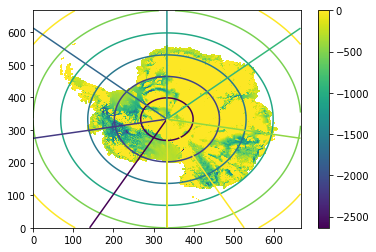

In [31]:
plt.close()
plt.pcolormesh(bedmap['zice'],vmax=0)
plt.colorbar()
plt.contour(bedmap['lat'])
plt.contour(bedmap['lon'])
plt.show()

In [4]:
susheel_raw_path = os.path.join(data_dir,'external','susheel','ant_all_meltrate_2011-2017_10km_filt.nc')
susheel = xr.open_dataset(susheel_raw_path)

In [5]:
from dask.distributed import Client
c = Client()
c

Client Scheduler: tcp://127.0.0.1:60310 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 16 Cores: 16 Memory: 101.38 GB


In [15]:
susheel.lat.chunk?

In [6]:
ii = bedmap['mask_ice']==1
bla = bedmap['lat'][ii]
blo = bedmap['lon'][ii]
bz = bedmap['zice'][ii]

sla = susheel.lat.values
slo = susheel.lon.values

susheel_zice=griddata((bla,blo),bz,(sla,slo),method='nearest')

In [7]:
susheel['zice']=xr.DataArray(susheel_zice,dims=('x','y'))
susheel=susheel.chunk(1000)
susheel['zice'] = susheel.zice.where(~susheel.w_b.isnull())
susheel.to_netcdf(os.path.join(data_dir,'processed','susheel_with_bedmap_zice.nc'))

<IPython.core.display.Javascript object>


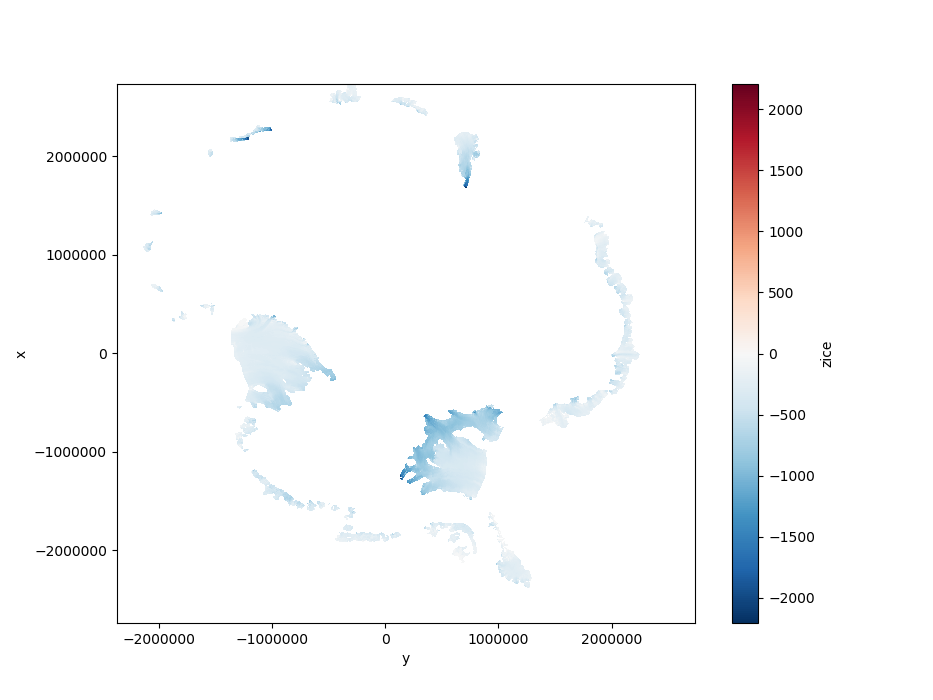

In [20]:
%matplotlib notebook

plt.close()
susheel.zice.plot(size=7)
plt.show()

In [32]:
from tools.cartesian_grid_2d import haversine
lat = susheel.lat
lon = susheel.lon
dy = haversine(lon[:,0:-1],lat[:,0:-1],lon[:,1:],lat[:,1:]).values
dx = haversine(lon[0:-1,:],lat[0:-1,:],lon[1:,:],lat[1:,:]).values

In [35]:
# Interpolate dy to the rho-grid
w_bdry_dy = dy[:,0]
middle_dy = 0.5*(dy[:,0:-1] + dy[:,1:])
e_bdry_dy = dy[:,-1]
dy_rho = np.concatenate((w_bdry_dy[:,None], middle_dy, e_bdry_dy[:,None]), axis=1)
# Interplate dx to the rho-grid
s_bdry_dx = dx[0,:]
middle_dx = 0.5*(dx[0:-1,:] + dx[1:,:])
n_bdry_dx = dx[-1,:]
dx_rho = np.concatenate((s_bdry_dx[None,:], middle_dx, n_bdry_dx[None,:]), axis=0)

In [40]:
susheel['dx']=xr.DataArray(dx_rho,dims=('x','y'))
susheel['dy']=xr.DataArray(dy_rho,dims=('x','y'))
susheel['mask']= ~susheel.w_b.isnull()

In [41]:
rhoi = 916
mask = susheel.mask

dA = (susheel.dx*susheel.dy).where(mask)
weights = dA/dA.sum()

ismr = (susheel.w_b.where(mask)*weights).sum()
bmb = (susheel.w_b.where(mask)*dA*rhoi*10**-12).sum()

print('Area of all ice shelves in 10^3 km^2: ',dA.sum().values*10**-9)
print('Area average melt rate in m/yr: ',ismr.values)
print('Basal mass loss in Gt/a: ',bmb.values)

Area of all ice shelves in 10^3 km^2:  1402.3164866450973
Area average melt rate in m/yr:  0.5910127272737138
Basal mass loss in Gt/a:  759.1687924060783


In [42]:
bins = np.arange(0,2800,100)
depths = susheel.zice*-1
ismr2bmb = dA*rhoi*(10**-12)

ismr = (susheel.w_b.where(mask).groupby_bins(depths,bins).mean()).to_series()
A = dA.groupby_bins(depths,bins).sum().to_series()/10**9
bmb =  ((susheel.w_b.where(mask)*ismr2bmb).groupby_bins(depths,bins).sum()).to_series()

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:34602 remote=tcp://127.0.0.1:60310>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:34603 remote=tcp://127.0.0.1:60310>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:34604 remote=tcp://127.0.0.1:60310>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:34605 remote=tcp://127.0.0.1:60310>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:34606 remote=tcp://127.0.0.1:60310>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:34607 remote=tcp://127.0.0.1:60310>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:34608 remote=tcp://127.0.0.1:60310>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:34613 remote=tcp://127.0.0.1:60310>
distributed.comm

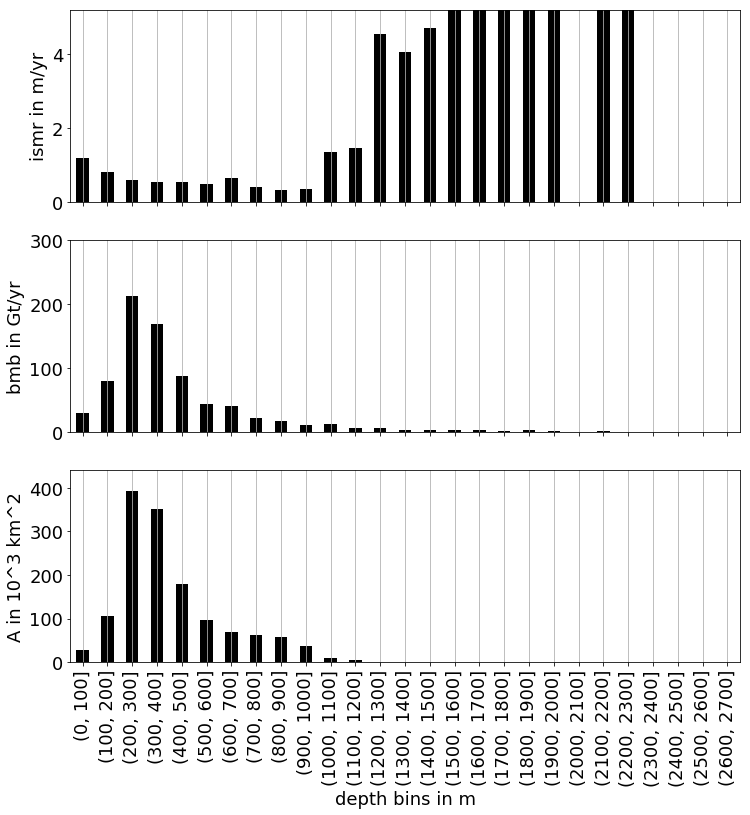

In [59]:
plt.rcParams.update({'font.size': 18})
plt.close()
fig,axes = plt.subplots(3,figsize=(12,12))
ax1,ax2,ax3 = axes.flatten()
ismr.plot.bar(ax=ax1,color='k')
bmb.plot.bar(ax=ax2,color='k')
A.plot.bar(ax=ax3,color='k')
ax1.set_ylabel('ismr in m/yr')
ax2.set_ylabel('bmb in Gt/yr')
ax3.set_ylabel('A in 10^3 km^2')
for ax in [ax1,ax2]:
    #ax.set_xticks([])
    ax.set_xticklabels('')
    ax.set_xlabel('')
    ax.xaxis.grid(True)
ax3.xaxis.grid(True)
ax3.set_xlabel('depth bins in m')
ax1.set_ylim(0,5.2)
ax2.set_ylim(0,300)
ax3.set_ylim(0,440)
plt.savefig(os.path.join(fig_dir,'susheel_depth_bins.png'),transparent=True,dpi=300,bbox_inches = "tight")
plt.show()

In [55]:
bmb.loc[slice(0,400)].sum()/bmb.sum()

0.646048279750365

In [ ]:
mask_sector = np.load(os.path.join(int_dir,'sector2.npy'))

sec_depth = {}

for sec_key,sec_mask in log_progress(mask_sector.items(),name='sector'):
    sec_depth[sec_key]={}
    
    for depth_key,depth_mask in mask_depth.items():
        
        mask = sec_mask & depth_mask

        dA = (1/(grd.pm*grd.pn)).where(mask)
        weights = dA/dA.sum()

        ismr2bmb = dA*rhoi*(10**-12)

        sec_depth[sec_key]["A "+depth_key] = dA.sum().values*10**-9
        sec_depth[sec_key]["ismr "+depth_key] = (m.where(mask)*weights).sum().values*s2a
        sec_depth[sec_key]["bmb "+depth_key] = (m.where(mask)*ismr2bmb).sum().values*s2a
        
df_melt = pd.DataFrame.from_dict(sec_depth, orient='index').T

In [290]:
def make_mask_front(grd,nb_cells):
    
    mask_rho = grd.mask_rho.values
    mask_land = np.zeros_like(mask_rho)
    mask_land[mask_rho == 0] = 1
    mask_zice = np.zeros_like(mask_land)
    mask_zice[grd.zice.values*mask_rho != 0] = 1

    mask_front = np.zeros_like(grd.mask_rho.values)

    for j in grd.eta_rho.values:
        for i in grd. xi_rho.values:
            if mask_zice[j,i] == 1:
                j_min = max(j-nb_cells,0)
                j_max = min(j+nb_cells, np.size(mask_rho,0))
                i_min = max(i-nb_cells,0)
                i_max = min(i+nb_cells+1, np.size(mask_rho,1))

                if np.any(mask_zice[j_min:j_max,i_min:i_max] + mask_land[j_min:j_max,i_min:i_max]== 0):
                        mask_front[j,i] = 1
                        
    grd['mask_front'] = (('eta_rho','xi_rho'),mask_front)
    
    return grd

In [291]:
waom_grd = make_mask_front(waom_grd,2)

In [292]:
import pandas as pd
def make_mass_loss_table(m,grd,
                         google_sheet_url='https://docs.google.com/spreadsheets/d/1BpI6iRB569kF7TxdiFT3ColNVH9zwHgNwq49Dat7Ok4/edit?usp=sharing',
                        idx_start=0,idx_end=69,include_no_front=True):
    
    csv_export_url = google_sheet_url.replace('edit?', 'export?gid=0&format=csv&')
    IS = pd.read_csv(csv_export_url)

    rhoi = 916

    mask_ice = (grd.mask_rho==1) & (grd.zice<0)

    for idx,row in log_progress(IS.iloc[idx_start:idx_end].iterrows(),name='Ice shelf',every=1): 

        if row.lon_min<row.lon_max:
            mask_coord = (grd.lon_rho>row.lon_min) & (grd.lon_rho<=row.lon_max) & (grd.lat_rho>row.lat_min) & (grd.lat_rho<=row.lat_max)
        else:
            mask_coord = ((grd.lon_rho>row.lon_min) | (grd.lon_rho<=row.lon_max)) & (grd.lat_rho>row.lat_min) & (grd.lat_rho<=row.lat_max)

        mask_shelf = mask_ice & mask_coord
        
        dA = (1/(grd.pm*grd.pn)).where(mask_shelf)
        weights = dA/dA.sum()
        
        dA_l = dA.where(m > 0.0)
        weights_l = dA_l/dA_l.sum()
        
        dA_g = dA.where(m < 0.0)
        weights_g = dA_g/dA_g.sum()
        
        ismr2bmb = dA*rhoi*(10**-12)

        IS.at[idx,"A"] = float(dA.sum().values)*10**-9
        IS.at[idx,"ismr"] = float((m.where(mask_shelf)*weights).sum().values)
        IS.at[idx,"ismr_l"] = float((m.where(mask_shelf & (m > 0.0))*weights_l).sum().values)
        IS.at[idx,"ismr_g"] = float((m.where(mask_shelf & (m < 0.0))*weights_g).sum().values)
        IS.at[idx,"bmb"] = float((m.where(mask_shelf)*ismr2bmb).sum().values)
        IS.at[idx,"bml"] = float((m.where(mask_shelf & (m > 0.0))*ismr2bmb).sum().values)
        IS.at[idx,"bmg"] = float((m.where(mask_shelf & (m < 0.0))*ismr2bmb).sum().values)
        
        if include_no_front:
            
            dA = dA.where(grd.mask_front == 0)
            weights = dA/dA.sum()
            
            dA_l = dA.where(m > 0.0)
            weights_l = dA_l/dA_l.sum()

            dA_g = dA.where(m < 0.0)
            weights_g = dA_g/dA_g.sum()
            
            ismr2bmb = dA*rhoi*(10**-12)
            
            IS.at[idx,"A_nf"] = float(dA.sum().values)*10**-9
            IS.at[idx,"ismr_nf"] = float((m.where(mask_shelf & (grd.mask_front == 0))*weights).sum().values)
            IS.at[idx,"ismr_nf_l"] = float((m.where(mask_shelf & (grd.mask_front == 0) & (m > 0.0))*weights_l).sum().values)
            IS.at[idx,"ismr_nf_g"] = float((m.where(mask_shelf & (grd.mask_front == 0) & (m < 0.0))*weights_g).sum().values)
            IS.at[idx,"bmb_nf"] = float((m.where(mask_shelf & (grd.mask_front == 0))*ismr2bmb).sum().values)
            IS.at[idx,"bml_nf"] = float((m.where(mask_shelf & (grd.mask_front == 0) & (m > 0.0))*ismr2bmb).sum().values)
            IS.at[idx,"bmg_nf"] = float((m.where(mask_shelf & (grd.mask_front == 0) & (m < 0.0))*ismr2bmb).sum().values)

        
    return IS

In [293]:
IS = make_mass_loss_table(wb,waom_grd,include_no_front=True)
IS

,Names,lat_min,lon_min,lat_max,lon_max,A,ismr,ismr_l,ismr_g,bmb,bml,bmg,A_nf,ismr_nf,ismr_nf_l,ismr_nf_g,bmb_nf,bml_nf,bmg_nf
0,Larsen G,-74.70,-62.55,-74.36,-61.35,0.44,-2.72,3.09,-4.27,-1.10,0.26,-1.36,0.38,-3.70,2.10,-4.25,-1.28,0.06,-1.34
1,Larsen F,-74.44,-61.96,-73.85,-60.55,0.96,2.21,3.29,-5.88,1.94,2.55,-0.61,0.73,1.90,3.32,-5.88,1.27,1.88,-0.61
2,Larsen E,-73.72,-62.61,-73.11,-60.05,1.33,2.20,3.78,-1.04,2.68,3.10,-0.42,1.12,1.75,3.55,-1.04,1.79,2.21,-0.42
3,Larsen D,-73.00,-62.70,-69.40,-59.30,14.43,2.14,3.01,-2.42,28.23,33.38,-5.16,12.95,2.19,3.15,-2.50,25.94,31.02,-5.07
4,Larsen C,-69.30,-65.50,-66.10,-60.00,55.66,0.61,1.24,-0.44,30.99,39.46,-8.46,54.07,0.61,1.24,-0.42,30.35,38.22,-7.86
5,Larsen B,-66.10,-62.75,-65.00,-59.00,4.45,1.17,2.15,-1.13,4.77,6.15,-1.38,3.19,1.38,2.39,-1.08,4.01,4.93,-0.92
6,Wordie,-69.49,-68.24,-68.75,-66.86,0.96,3.67,3.67,0.00,3.23,3.23,0.00,0.53,3.96,3.96,0.00,1.94,1.94,0.00
7,Wilkins,-71.50,-75.00,-69.70,-69.50,15.12,3.56,3.56,0.00,49.30,49.30,0.00,13.00,3.28,3.28,0.00,39.06,39.06,0.00
8,Bach,-72.38,-75.37,-71.50,-70.30,5.33,3.78,3.92,-2.83,18.47,18.74,-0.27,4.57,2.85,2.93,-1.78,11.93,12.05,-0.12
9,George VI 1,-73.80,-74.50,-72.60,-67.00,12.91,3.58,3.59,-0.22,42.37,42.37,-0.00,12.15,3.58,3.58,-0.22,39.83,39.83,-0.00


In [294]:
def merge_patches(df,name1,name2,name):
    p1 = df.loc[df['Names'] == name1]
    p2 = df.loc[df['Names'] == name2]
    
    m = {'Names':name,'A':np.nan,'bmb':np.nan,'bml':np.nan,'bmg':np.nan,'ismr':np.nan,'ismr_l':np.nan,'ismr_g':np.nan,
         'A_nf':np.nan,'bmb_nf':np.nan,'bml_nf':np.nan,'bmg_nf':np.nan,'ismr_nf':np.nan,'ismr_nf_l':np.nan,'ismr_nf_g':np.nan,}
    for key in ['A','bmb','bml','bmg','A_nf','bmb_nf','bml_nf','bmg_nf']:
        m[key] = p1[key].values + p2[key].values
    for key in ['ismr','ismr_l','ismr_g','ismr_nf','ismr_nf_l','ismr_nf_g']:    
        m[key] = ((p1[key]*p1.A_nf).values + (p2[key]*p2.A_nf).values) / m['A_nf']
    
    df = pd.concat([df,pd.DataFrame(m)],ignore_index=True)

    return df

In [295]:
IS_merged = merge_patches(IS,'George VI 1','George VI 2','George VI')
IS_merged = merge_patches(IS_merged,'Ronne','Filchner','Ronne-Filchner')
IS_merged = merge_patches(IS_merged,'Moscow University','Totten','Moscow Uni + Totten')
IS_merged = merge_patches(IS_merged,'Brunt/Stancomb','Riiser-Larsen','Brunt + Riiser-Larsen')
IS_merged = merge_patches(IS_merged,'Fimbul','Jelbart','Fimbul + Jelbart')
IS_merged = merge_patches(IS_merged,'Ross West','Ross East','Ross')

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if sys.path[0] == '':


In [296]:
IS_out = IS_merged[['Names','A','bmb','ismr',
                    'A_nf','bmb_nf','ismr_nf',
                    'bml','bmg','ismr_l','ismr_g',
                    'bml_nf','bmg_nf','ismr_nf_l','ismr_nf_g',
                    'lon_min','lat_min','lon_max','lat_max']] 

pd.options.display.float_format = '{:,.2f}'.format

IS_out

,Names,A,bmb,ismr,A_nf,bmb_nf,ismr_nf,bml,bmg,ismr_l,ismr_g,bml_nf,bmg_nf,ismr_nf_l,ismr_nf_g,lon_min,lat_min,lon_max,lat_max
0,Larsen G,0.44,-1.10,-2.72,0.38,-1.28,-3.70,0.26,-1.36,3.09,-4.27,0.06,-1.34,2.10,-4.25,-62.55,-74.70,-61.35,-74.36
1,Larsen F,0.96,1.94,2.21,0.73,1.27,1.90,2.55,-0.61,3.29,-5.88,1.88,-0.61,3.32,-5.88,-61.96,-74.44,-60.55,-73.85
2,Larsen E,1.33,2.68,2.20,1.12,1.79,1.75,3.10,-0.42,3.78,-1.04,2.21,-0.42,3.55,-1.04,-62.61,-73.72,-60.05,-73.11
3,Larsen D,14.43,28.23,2.14,12.95,25.94,2.19,33.38,-5.16,3.01,-2.42,31.02,-5.07,3.15,-2.50,-62.70,-73.00,-59.30,-69.40
4,Larsen C,55.66,30.99,0.61,54.07,30.35,0.61,39.46,-8.46,1.24,-0.44,38.22,-7.86,1.24,-0.42,-65.50,-69.30,-60.00,-66.10
5,Larsen B,4.45,4.77,1.17,3.19,4.01,1.38,6.15,-1.38,2.15,-1.13,4.93,-0.92,2.39,-1.08,-62.75,-66.10,-59.00,-65.00
6,Wordie,0.96,3.23,3.67,0.53,1.94,3.96,3.23,0.00,3.67,0.00,1.94,0.00,3.96,0.00,-68.24,-69.49,-66.86,-68.75
7,Wilkins,15.12,49.30,3.56,13.00,39.06,3.28,49.30,0.00,3.56,0.00,39.06,0.00,3.28,0.00,-75.00,-71.50,-69.50,-69.70
8,Bach,5.33,18.47,3.78,4.57,11.93,2.85,18.74,-0.27,3.92,-2.83,12.05,-0.12,2.93,-1.78,-75.37,-72.38,-70.30,-71.50
9,George VI 1,12.91,42.37,3.58,12.15,39.83,3.58,42.37,-0.00,3.59,-0.22,39.83,-0.00,3.58,-0.22,-74.50,-73.80,-67.00,-72.60


In [297]:
IS_out.to_csv(mass_loss_table_out_path)